In [ ]:
!pip install matplotlib-label-lines

In [ ]:
import sys
# !{sys.executable} -m pip install
!conda install -c conda-forge --yes --prefix {sys.prefix} cartopy_offlinedata

In [755]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import shapely
from shapely import ops, affinity
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry import MultiPolygon, LineString, MultiLineString
import geopy as gp
import geopy.distance
from labellines import labelLine, labelLines
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as ctp
import matplotlib.ticker as mticker
import itertools
from geographiclib.geodesic import Geodesic
import geopandas as gpd
from shapely import ops, affinity
from cartopy.io.shapereader import Reader

In [4]:
ctp.config['pre_existing_data_dir'] = '/usr/local/Caskroom/miniconda/base/pkgs/cartopy_offlinedata-0.2.3-pyh9f0ad1d_0/share/cartopy'
%matplotlib inline

In [5]:
start = gp.Point(48.853, 2.349)
d = gp.distance.distance(kilometers = 1)
d.destination(point=start, bearing=0)

Point(48.861992241626346, 2.349, 0.0)

In [6]:
degs = np.arange(0,360,1)

In [7]:
circle = [tuple(d.destination(point=start, bearing=a)) for a in degs]

In [8]:
poly_circ = Polygon(circle)

In [9]:
%matplotlib inline

In [62]:
cat = np.asarray([1,2,3,5,6])
print(cat, np.asarray(cat))
cat/cat

[1 2 3 5 6] [1 2 3 5 6]


array([1., 1., 1., 1., 1.])

In [343]:
class plotter:
    def __init__(self):
        self.fig = plt.figure(figsize=(8, 8), dpi=150)
        self.ax = self.fig.add_subplot(111, projection=ccrs.PlateCarree())
        self.ax.set_global()
#         self.ax.stock_img()
        self.ax.add_feature(cfeature.NaturalEarthFeature(category='physical', name='land', scale='10m', facecolor='none'), edgecolor='gray')
        self.ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='roads', scale='10m', facecolor='none'), edgecolor='gray')
        self.ax.add_feature(cfeature.COASTLINE)
        self.ax.add_feature(cfeature.OCEAN)
        self.grids = self.ax.gridlines
        self.circ_data = { #turns out it's very slow to iteratively add to a pandas df so we're gonna hold the data in a dictionary until we need to do pandas shit on it
            "coord_point":[],
            "latitude":[],
            "longitude":[],
            "stated_radius":[],
            "shapely_poly":[],
        }
    
    def _whm(self, vals, weights): #weighted harmonic mean
        vals, weights = np.asarray(vals), np.asarray(weights)
        whm = np.sum(weights)/np.sum(weights/vals)
        return whm
    
    def _wam(self, vals, weights): #weighted algebraic mean
        vals, weights = np.asarray(vals), np.asarray(weights)
        return np.average(vals, weights=weights)
    
    def get_poly_circ(self, point, radiusmiles):
        d = gp.distance.distance(miles = radiusmiles)
        degs = np.arange(0,360,1)
        circle = [tuple(d.destination(point=point, bearing=a)) for a in degs]
        poly_circ = Polygon(circle)
        return poly_circ
    
    def add_to_records(self, circ_dict, point, radiusmiles, shapelypoly=None):
        if shapelypoly is None:
            shapelypoly = self.get_poly_circ(point, radiusmiles)
        else: pass
    
        circ_dict["coord_point"].append(point)
        circ_dict["latitude"].append(point.latitude)
        circ_dict["longitude"].append(point.longitude)
        circ_dict["stated_radius"].append(radiusmiles)
        circ_dict["shapely_poly"].append(shapelypoly)
    
    def add_to_plt(self, ax, circ, pt=None, showrad=False):
        rgb = (np.random.rand(), np.random.rand(), np.random.rand())
        ax.plot(*(circ.exterior.xy[::-1]), linewidth=1, markersize=2, marker='x', color=rgb)
        bounds = MultiPolygon([a for a in self.circ_data["shapely_poly"]]).bounds #Shapely returns bounds as a (xmin, ymin, xmax, ymax) tuple.
        bounds = [bounds[1], bounds[3], bounds[0], bounds[2]] #however, cartopy expects a  (xmin, xmax, ymin, ymax) tuple
#         print("="*20)
#         print(np.vstack(circ.exterior.xy[::-1]).T[:2])
#         print("bounds:"+str(bounds))
        ax.set_xlim(bounds[:2])
        ax.set_ylim(bounds[-2:])
#         print("goal:[-122, -120, 37, 39]\n current:"+str(ax.get_extent()))

        if pt is not None:
#             ax.plot(pt.latitude, pt.longitude, markersize=3, marker='o', color=rgb)
            if showrad:
                pass
                #whoops, need to reverse-engineer the radius lol
                rad = gp.distance.distance(pt, geopy.point.Point([*circ.exterior.xy][0][0],[*circ.exterior.xy][1][0])).miles
                ax.plot([pt.longitude, [*circ.exterior.xy][1][0]],[pt.latitude, [*circ.exterior.xy][0][0]], lw=1, ls='--', color=rgb, alpha=0.5, label=f"r={np.round(rad,2)} mi")
                labelLines(self.fig.gca().get_lines()[-1:],0.6,xvals=(pt.longitude, [*circ.exterior.xy][1][0]),backgroundcolor='none', zorder=2.5)
#                 print(r"radius things:")
#                 print([pt.latitude, [*circ.exterior.xy][0][0]],[pt.longitude, [*circ.exterior.xy][1][0]])


        if pt is None and showrad:
            pass
    
    def add_radial(self, point, radiusmiles):
        if type(point) == geopy.point.Point:
            pass
        else:
            point = gp.point(point)
        
        poly_circ = self.get_poly_circ(point, radiusmiles)
        self.add_to_records(self.circ_data, point, radiusmiles, poly_circ)
        self.add_to_plt(self.ax, poly_circ, point, showrad=True)
        
    def centroid_guesser(self, circleset=None):
        #guess that the "true" radius is r_given*(1+a), 0<a<1
        #for all centerpoints and asserted radii p, r_given in circ_dict, there exists some a such that r_given_1(1+a) . r_given_2(1+a) . ... intersect at exactly one point
        #head foggy no math explain: if you find the mean value of the centerpoints of the circles for each pair of circles as weighted by the stated radius, that's where expanding the circles would meet
        #then take the line perpindicular to the line connecting those two centerpoints == a line mutually tangent to the circles at the place where they would first touch
        #then the place where all three of *those* lines meet is the true location.
        
        if circleset is None: circleset = self.circ_data
        
        circpanda = pd.DataFrame({
            "center": circleset["coord_point"],
            "longitude": circleset["longitude"],
            "latitude": circleset["latitude"],
            "stated_radius": circleset["stated_radius"],
            "stated_circle": circleset["shapely_poly"],
            "true_radius": [np.NaN]*len(circleset["coord_point"]),
        })
        
        seekerlines = []
        for (p1, p2) in itertools.combinations(np.arange(len(circpanda)),2):
            cent1, cent2 = circpanda.at[p1, "center"], circpanda.at[p2, "center"]
            r1, r2 = circpanda.at[p1, "stated_radius"], circpanda.at[p2, "stated_radius"]
            x_cen = self._wam([cent1.longitude, cent2.longitude], [1/r1,1/r2]) #self._whm([cent1.longitude, cent2.longitude], [1/r1**2,1/r2**2])
            y_cen = self._wam([cent1.latitude, cent2.latitude], [1/r1,1/r2]) #self._whm([cent1.latitude, cent2.latitude], [1/r1**2,1/r2**2])
#             print("\nCENTERPOINTS:")
#             print(cent1, cent2)
#             print("\nRADII:")
#             print(r1, r2)
#             print("\nCENTROID:")
            print("x_cen ", x_cen, "; y_cen ", y_cen)
            self.ax.plot(circpanda["longitude"].loc[[p1,p2],].to_numpy(), circpanda["latitude"].loc[[p1,p2],].to_numpy(), lw=1, ls=':', color="gray", alpha=0.5)
            self.ax.plot(x_cen, y_cen, ms=2, marker='o', color="black")
        
            oldline = LineString([tuple(cent1)[:2][::-1],tuple(cent2)[:2][::-1]])
            bearing = Geodesic.WGS84.Inverse(cent1.latitude, cent1.longitude, cent2.latitude, cent2.longitude)["azi1"]
            perp_bear = bearing-90
            print("bearings", bearing, perp_bear)
            dists = np.arange(-1000,1000,1)
            newline = [list(gp.distance.distance(miles = a).destination(point=gp.Point(y_cen, x_cen), bearing=perp_bear)) for a in dists]
            plotline = (np.asarray(newline).T)[:2][::-1]
            seekerlines.append([tuple(a[:2]) for a in newline])
            self.ax.plot(plotline[0], plotline[1], lw=1, ls=':', color="black", alpha=0.5)
        
        guessbox = MultiLineString(seekerlines)
#         print(seekerlines)
        guessbox = Polygon([a.intersection(b) for a, b in itertools.combinations(guessbox.geoms,2)])
        new_guess = guessbox.centroid.coords
        return new_guess

In [175]:
ncc_sf = gp.Point(37.7929223,-122.4074297)
capitol = gp.Point(38.5765882,-121.4954255)
winery = gp.Point(38.3380146,-122.3902176)

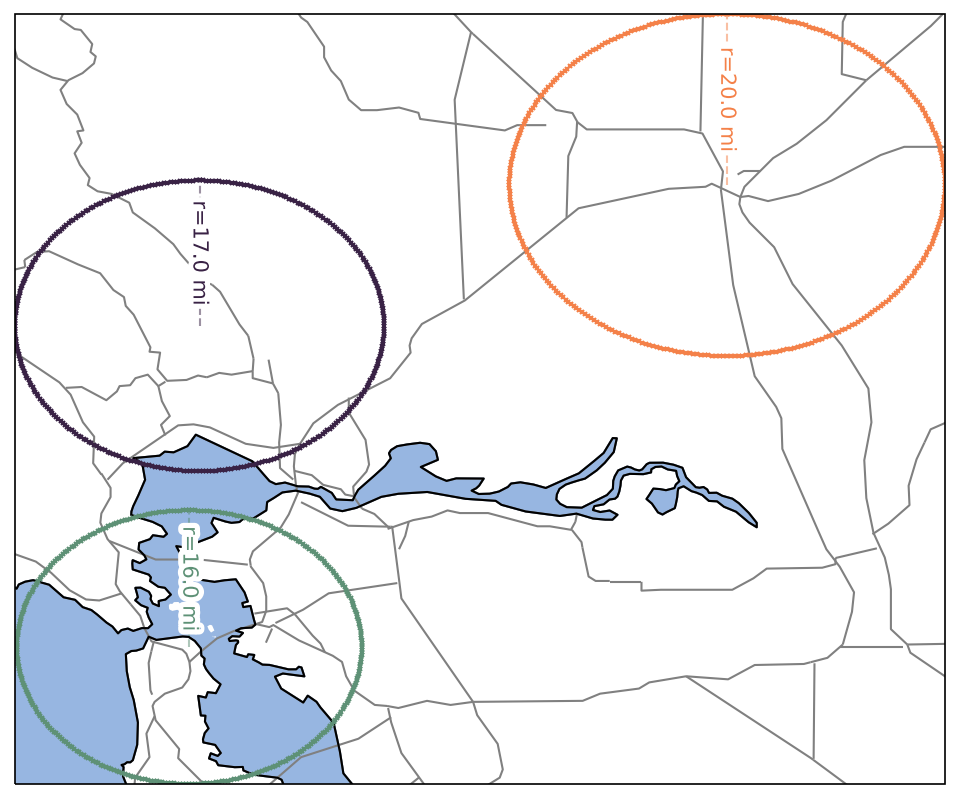

In [344]:
test = plotter()
test.add_radial(ncc_sf, 16)
test.add_radial(capitol, 20)
test.add_radial(winery,17)

In [345]:
cat = test.expand_fuzzy()

x_cen  -122.0020945 ; y_cen  38.14121825555556
bearings 42.288072158317384 -47.711927841682616
x_cen  -122.39908443939395 ; y_cen  38.057209475757574
bearings 1.4247473330014127 -88.5752526669986
x_cen  -121.9790969054054 ; y_cen  38.4476294972973
bearings -108.45236393120501 -198.452363931205


[  38.02447504 -121.82057736]
[38.0244750428575, -121.82057735533999]
[(38.0244750428575, -121.82057735533999)]


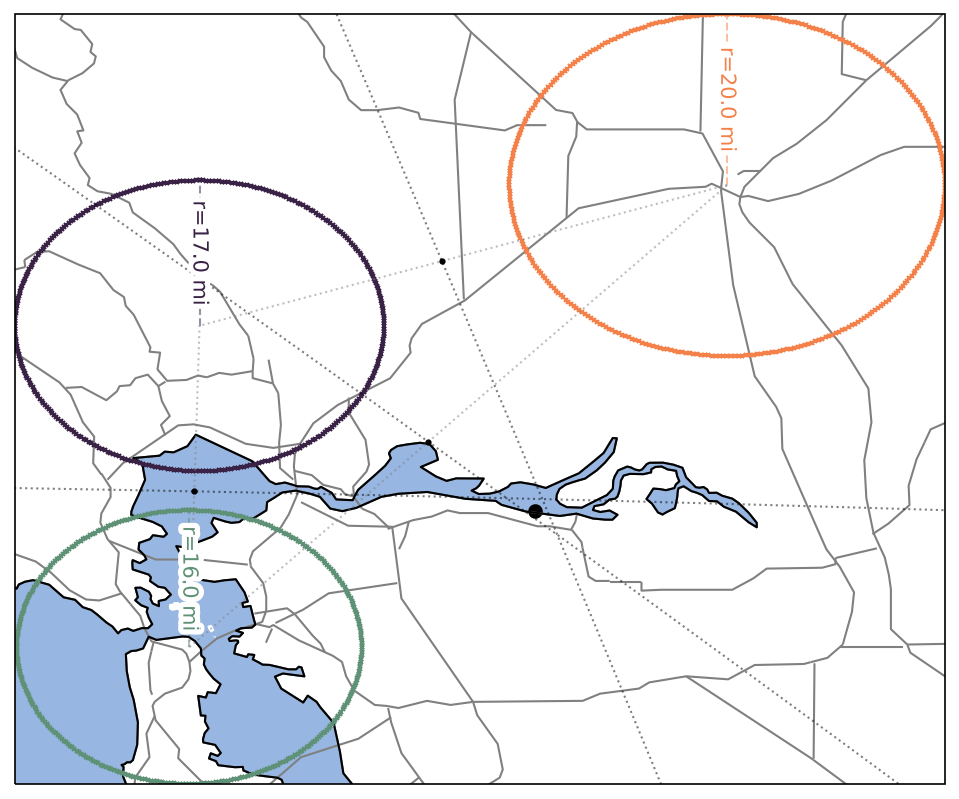

In [346]:
print(np.hstack(cat.xy))
foo=[a for a in list(*cat)]
print(foo)
test.__dict__["ax"].scatter(x=foo[1], y=foo[0], color="black")
print(list(cat))
test.__dict__["fig"]

In [300]:
def fuzzy_distance(p1, p2):
    if type(p1) == geopy.point.Point:
        pass
    else:
        p1 = gp.point(p1)
    if type(p2) == geopy.point.Point:
        pass
    else:
        p2 = gp.point(p2)
    
    actual_dist = gp.distance.distance(p1,p2).miles
    dist_error = np.random.normal(actual_dist, 1)#actual_dist/4)
    print(f"distance: {int(np.round(dist_error,0))} mi. (Don't tell anyone, but you're ACTUALLY {actual_dist} miles away)")
    return int(np.round(dist_error,0))


distance: 292 mi. (Don't tell anyone, but you're ACTUALLY 294.2836165078414 miles away)
distance: 438 mi. (Don't tell anyone, but you're ACTUALLY 437.44595231694944 miles away)
distance: 338 mi. (Don't tell anyone, but you're ACTUALLY 338.9897001174599 miles away)


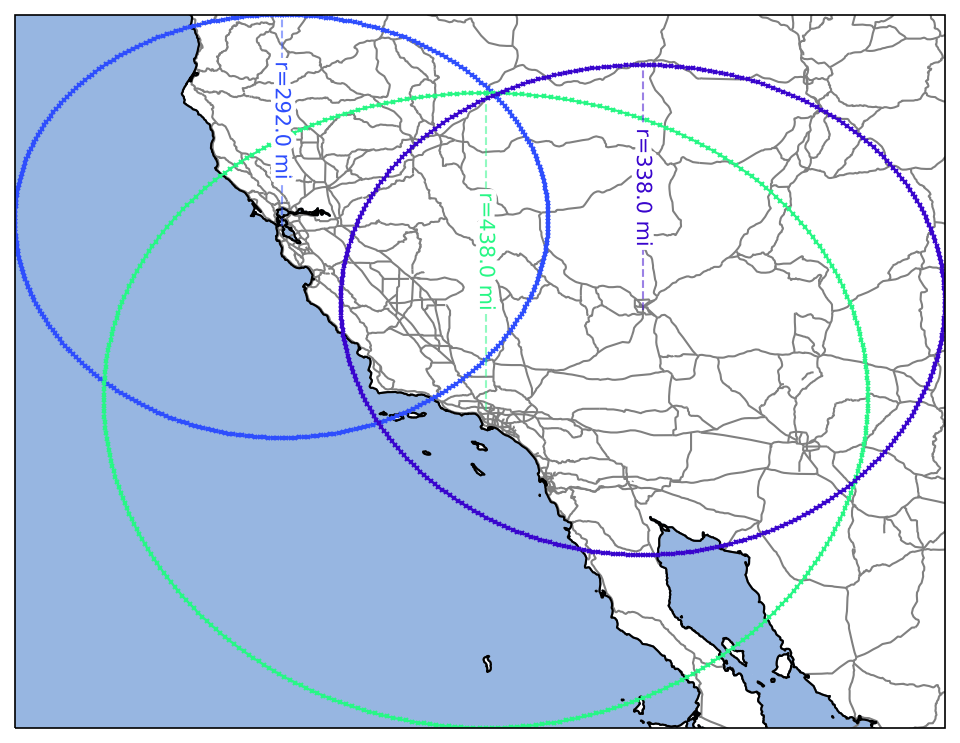

In [722]:
p1 = gp.Point(37.7880576,-122.4081408)
p2 = gp.Point(34.1046904,-118.3209208)
p3 = gp.Point(36.1129498,-115.1786954)
actual_location = gp.Point(40.4460444,-118.123232)
test = plotter()
test.add_radial(p1, fuzzy_distance(p1, actual_location))
test.add_radial(p2, fuzzy_distance(p2, actual_location))
test.add_radial(p3, fuzzy_distance(p3, actual_location))

In [519]:
def _masked_cartesian_product(intersections):
    arrays = np.asarray([[0,1],[0,1],[0,1]])
    la=len(arrays)
    dtype=np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    inds = arr.reshape(-1, la)
    polys = [Polygon([tuple(intersections[pt][i]) for pt, i in enumerate(i)]) for i in inds]
    return polys

def find_best_intersection(intersections):
    polys = _masked_cartesian_product(intersections)
    closest = polys[np.argmin([a.area for a in polys])]
    return np.asarray(closest.exterior.coords.xy).T

intersections = []
for a in itertools.combinations(test.__dict__['circ_data']['shapely_poly'],2):
    if a[0].intersection(a[1]).area>0:
        if not (a[0].contains(a[1]) \
        or a[0].within(a[1]) \
        or a[0].almost_equals(a[1], decimal=2)):
            intersections.append(np.asarray([(p.x, p.y) for p in (a[0].boundary).intersection(a[1].boundary)]))

new_guess = np.asarray(Polygon(find_best_intersection(intersections)).centroid.xy).T

In [483]:
# def _masked_cartesian_product(*arrays):


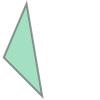

[[  40.4598543  -118.12414928]]
distance: 294 mi. (Don't tell anyone, but you're ACTUALLY 294.2836165078414 miles away)
distance: 2 mi. (Don't tell anyone, but you're ACTUALLY 0.954097242036042 miles away)
distance: 340 mi. (Don't tell anyone, but you're ACTUALLY 338.9897001174599 miles away)


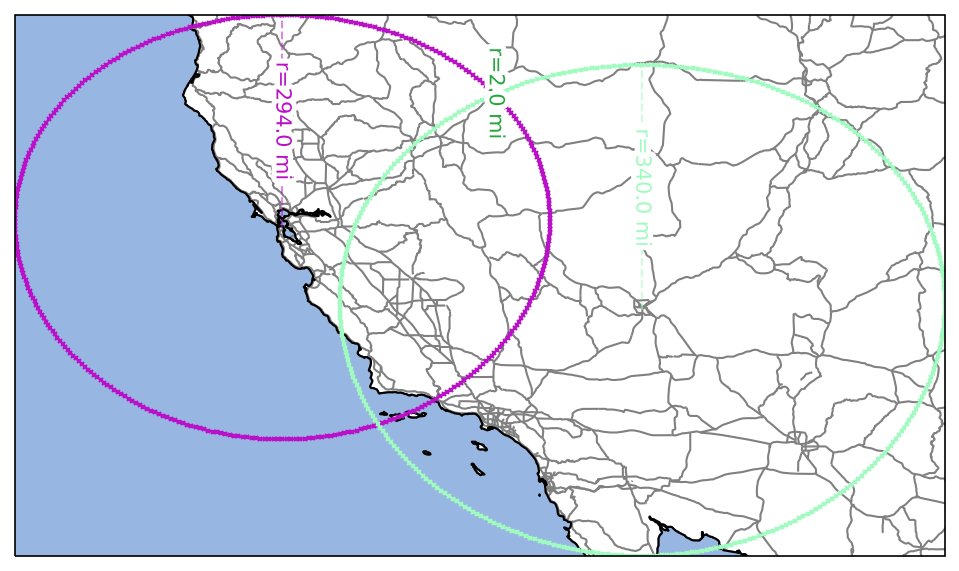

In [670]:
# new_guess = np.hstack(test.expand_fuzzy().xy)
print(new_guess)
p2 = gp.Point(new_guess)
# actual_location = gp.Point(40.4460444,-118.123232)
test = plotter()
test.add_radial(p1, fuzzy_distance(p1, actual_location))
test.add_radial(p2, fuzzy_distance(p2, actual_location))
test.add_radial(p3, fuzzy_distance(p3, actual_location))

x_cen  -118.1530951721296 ; y_cen  40.44180162249234
bearings 49.97974567276901 -40.02025432723099
x_cen  -119.0556850466877 ; y_cen  37.01127259495268
bearings 103.90741153969964 13.907411539699638
x_cen  -118.1069244069929 ; y_cen  40.43443380874835
bearings 150.97055793305591 60.970557933055915
[  40.41104656 -118.01479229]
[40.41104655510741, -118.0147922904906]
[(40.41104655510741, -118.0147922904906)]


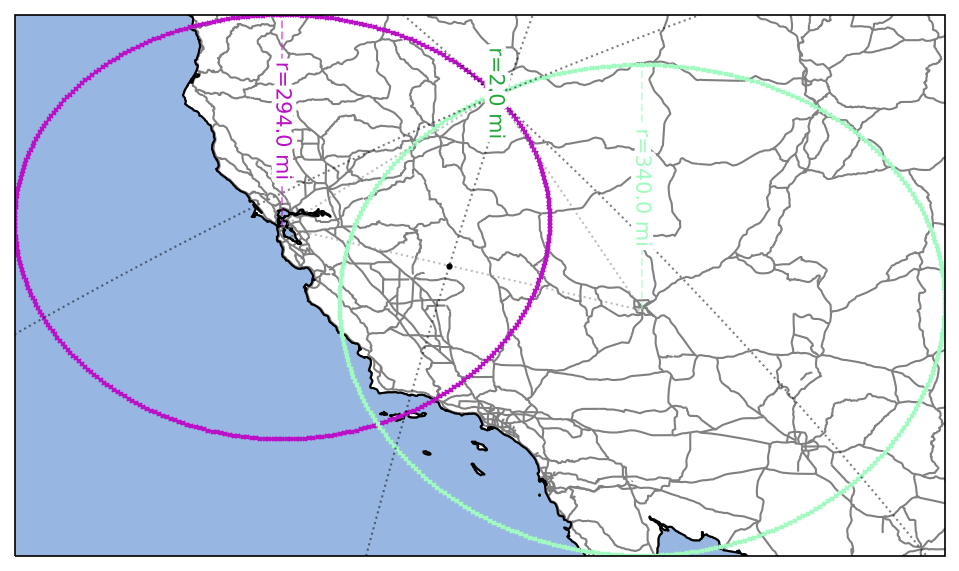

In [671]:
cat=test.expand_fuzzy()
print(np.hstack(cat.xy))
foo=[a for a in list(*cat)]
print(foo)
test.__dict__["ax"].scatter(x=foo[1], y=foo[0], color="black")
print(list(cat))
test.__dict__["fig"]

In [597]:
def build_relation_matrix(a,b,c):
    #this matrix is gonna be somewhat overdetermined/degenerate cuz that's just easier to write quickly than a "good" one.
    #this is also essentially a simplification of the DE-9IM classification model (https://giswiki.hsr.ch/images/3/3d/9dem_springer.pdf),
    #  which assumes that the geometries being compared are exclusively circles
    #also this should in reality be a sparse array bc the elements on/below the aa-bb-cc diagonal are redundant but again, idgaf
    x = np.array(["a","b","c"])
    y = np.array(["EQUALS", "CONTAINS", "WITHIN", "INTERSECTS", "TOUCHES"])
    mapping = {"a":a,"b":b,"c":c}
    tuples = [tuple(i) for i in np.dstack(np.meshgrid(x, y)).reshape(-1, 2, order="F")]
    index = pd.MultiIndex.from_tuples(tuples, names=["circle_1", "relation"])
    # index
    df = pd.DataFrame(np.ones((15, 3), dtype=bool), index=index, columns=["a","b","c"])
    pairs = np.dstack(np.meshgrid(x, x)).reshape(-1, 2)
    for pair in pairs:
        df[pair[0]][pair[1]]["EQUALS"] = mapping[pair[0]].almost_equals(mapping[pair[1]], decimal=2)
        df[pair[0]][pair[1]]["CONTAINS"] = mapping[pair[0]].contains(mapping[pair[1]])
        df[pair[0]][pair[1]]["WITHIN"] = mapping[pair[0]].within(mapping[pair[1]])
        df[pair[0]][pair[1]]["INTERSECTS"] = mapping[pair[0]].intersects(mapping[pair[1]])
        df[pair[0]][pair[1]]["TOUCHES"] = mapping[pair[0]].touches(mapping[pair[1]])
        
    return df

In [661]:
x = np.array(["a","b","c"])
mdeim = build_relation_matrix(*test.__dict__["circ_data"]["shapely_poly"])


def trinary_predicates(i, predicates, df=mdeim, axes=["a","b","c"], _or=True):
    other_two = filter(lambda x: x != i, axes)
    if type(predicates)==str:
        return list(df.loc[pd.IndexSlice[i,predicates], list(other_two)])
    elif type(predicates)==list:
        if _or: return list(np.logical_or(*np.array(df.loc[pd.IndexSlice[i,predicates], list(other_two)])))
        else: return list(df.loc[pd.IndexSlice[i,predicates], list(other_two)])
    else: raise TypeError

In [753]:
def too_flat(centerpoints, _maximal_angle=160):
    #centerpoints should be structured as a list of three points
    #_maximal_angle defines the angle at which a group of points is considered "too flat" to be useful
    interior_angles=np.empty((0,3), float)
    for i in centerpoints:
        i=np.asarray(i)
        other_two = np.asarray(list(filter(lambda x: (x != i).any(), centerpoints)))
        vectors = np.asarray([a-i for a in other_two])
    #     print(vectors)
        for x, vector in enumerate(vectors):
    #         print(x)
            vectors[x] = vector / np.linalg.norm(vector)
        angle = np.arccos(np.dot(*vectors))
        interior_angles = np.append(interior_angles, np.degrees(angle))

        return (interior_angles >= _maximal_angle).any()
    
too_flat([test.__dict__['circ_data']['coord_point'][i][:2] for i in np.arange(3)])

False

In [ ]:
for i in x:
    if True in trinary_predicates(i, "EQUALS"):
        #then you know one circle is redundant and should be discarded and replaced
    if trinary_predicates(i, "CONTAINS") == [True,True]:
        #then i contains both the other circles
        #do median guess
    if trinary_predicates(i["INTERSECTS","TOUCHES"]),  == [True,True]:
        #if it either overlaps or touches at a single point both other circles,
        #do smallest-overlap method
    if trinary_predicates(i, ["INTERSECTS","TOUCHES"]) == [False,False]:
        #if none of them overlap at all, do the centroid triangulation thing

In [652]:
for i in ["a","b","c"]:
    other_two = filter(lambda x: x != i, ["a","b","c"])
    print(i, mdeim.loc[pd.IndexSlice[i,["INTERSECTS","TOUCHES"]], list(other_two)])

a                          b      c
circle_1 relation                
a        INTERSECTS   True   True
         TOUCHES     False  False
b                          a      c
circle_1 relation                
b        INTERSECTS   True   True
         TOUCHES     False  False
c                          a      b
circle_1 relation                
c        INTERSECTS   True   True
         TOUCHES     False  False


In [663]:
trinary_predicates("a", "TOUCHES")

[False, False]

In [757]:
popdem = gpd.read_file('assets/Tract_2010Census_DP1/Tract_2010Census_DP1.shp')
# projection = ccrs.PlateCarree()

In [760]:
def _run_census_get(_coords, popdem):
    coords = gpd.GeoDataFrame(geometry = _coords, crs=popdem.crs)
    tracts_data = gpd.sjoin(coords, popdem)[["geometry","index_right","NAMELSAD10","INTPTLAT10","INTPTLON10","DP0010001"]]
    tracts_included = tracts_data.index_right.drop_duplicates().to_list()
    tract_pop = np.asarray([[a, popdem.iloc[a]["DP0010001"]] for a in tracts_included])
    tract = tract_pop[np.where(tract_pop[:,1]==np.amax(tract_pop[:,1]))[0]][0][0]
    tract_center = shapely.geometry.Point([float(a) for a in popdem.iloc[tract][["INTPTLAT10","INTPTLON10"]].to_list()])
    return tract_center

def guess_by_population(point, radiusmiles, popdem, second_choice=False):
    d = gp.distance.distance(miles = radiusmiles)
    degs = np.arange(0,360,1)
    circle = [tuple(d.destination(point=point, bearing=a)) for a in degs]
    poly_circ = LineString(circle)
    _coords = [shapely.geometry.Point(a) for a in np.fliplr(np.asarray(poly_circ.coords.xy).T)]
    
    tract_center = _run_census_get(_coords, popdem)
    endpt = ops.nearest_points(tract_center,poly_circ)[1]
    
    if not second_choice:
        return endpt
    
    else:
        bearing = Geodesic.WGS84.Inverse(point.latitude, point.longitude, *endpt.xy[0], *endpt.xy[1])["azi1"]
        degs = np.arange(0,360-20,1)
        degs = np.round((degs+bearing+10)%360,2)
        circle = [tuple(d.destination(point=point, bearing=a)) for a in degs]
        circ_frag = LineString(circle)
        _coords = [shapely.geometry.Point(a) for a in np.fliplr(np.asarray(poly_circ.coords.xy).T)]
        t2 = _run_census_get(_coords, popdem)
        t2 = ops.nearest_points(t2,circ_frag)[1]
        return endpt, t2

In [762]:
b = guess_by_population(ncc_sf, 10, popdem, second_choice=True)

In [771]:
ncc_sf

Point(37.7929223, -122.4074297, 0.0)

In [770]:
gp.Point(b[0].coords)

Point(37.920685809131406, -122.3209738107997, 0.0)

distance: 294 mi. (Don't tell anyone, but you're ACTUALLY 294.0387754638693 miles away)
distance: 294 mi. (Don't tell anyone, but you're ACTUALLY 294.2836165078414 miles away)
distance: 328 mi. (Don't tell anyone, but you're ACTUALLY 329.10442058929067 miles away)
distance: 285 mi. (Don't tell anyone, but you're ACTUALLY 285.4194375657376 miles away)


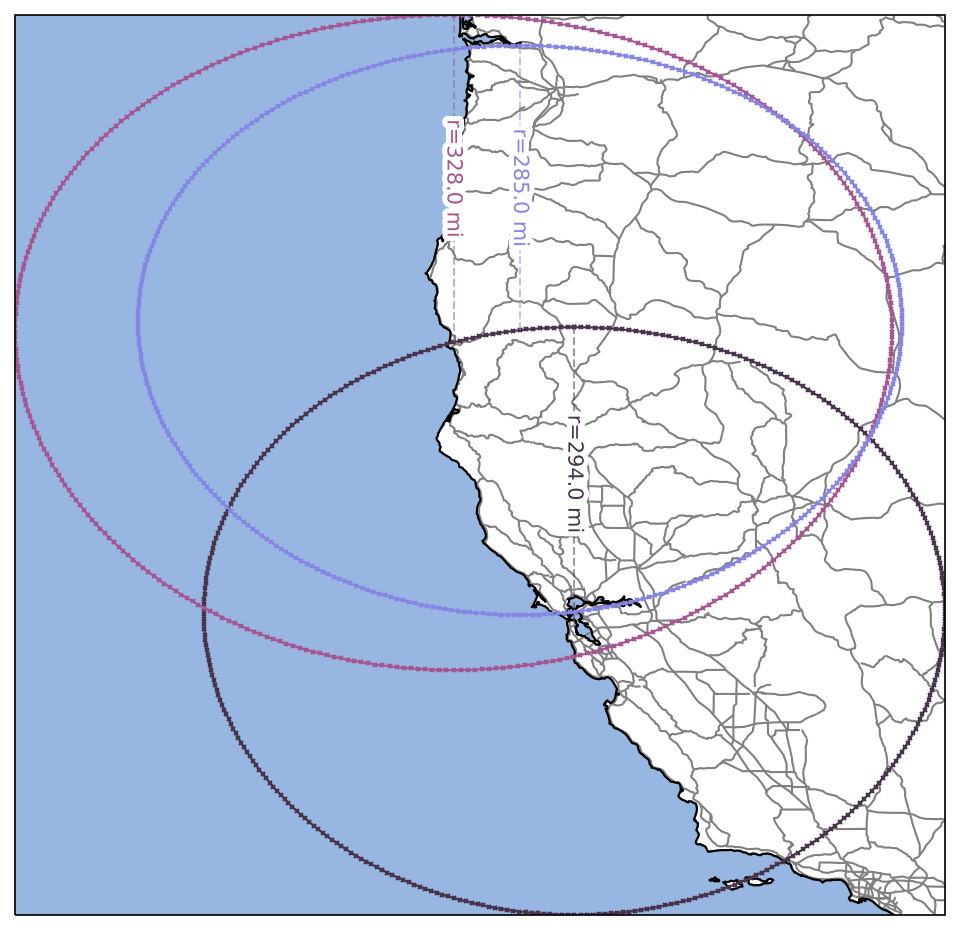

In [772]:
test = plotter()
b = guess_by_population(ncc_sf, fuzzy_distance(ncc_sf, actual_location), popdem, second_choice=True)
test.add_radial(ncc_sf, fuzzy_distance(p1, actual_location))
test.add_radial(gp.Point(b[0].coords), fuzzy_distance(gp.Point(b[0].coords), actual_location))
test.add_radial(gp.Point(b[1].coords), fuzzy_distance(gp.Point(b[1].coords), actual_location))

distance: 1 mi. (Don't tell anyone, but you're ACTUALLY 2.4358889349244577 miles away)


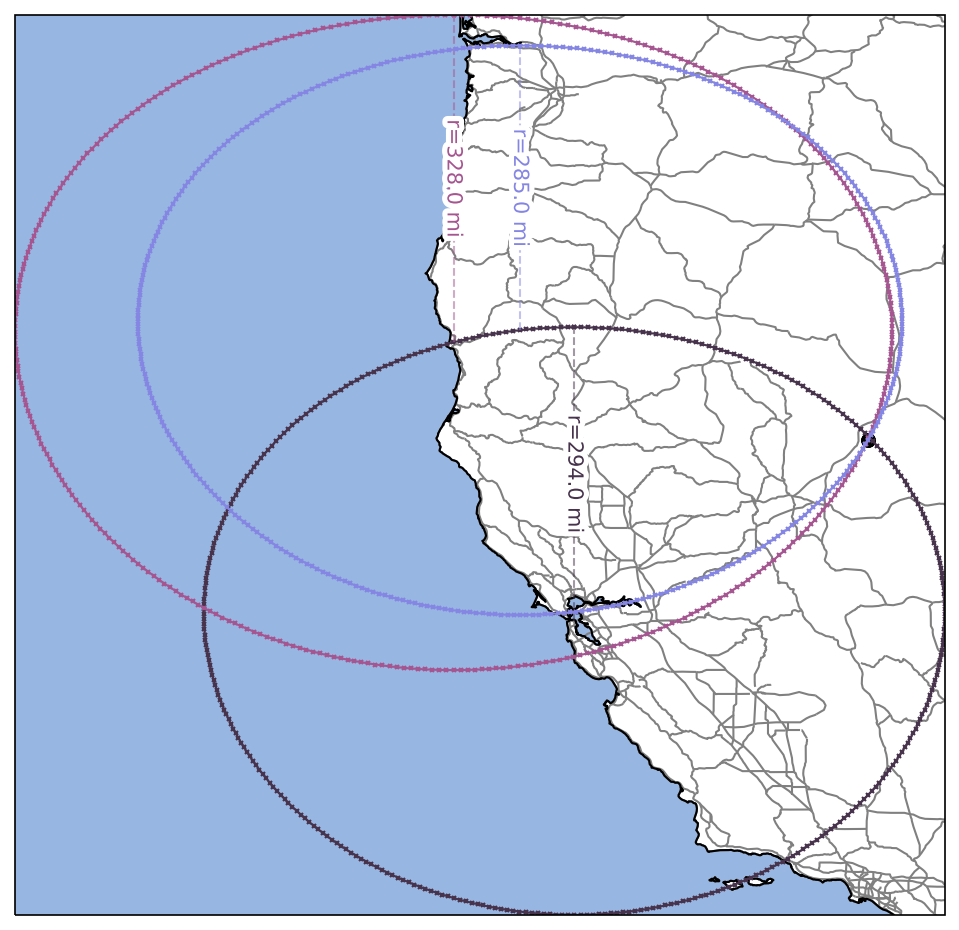

In [780]:
intersections = []
for a in itertools.combinations(test.__dict__['circ_data']['shapely_poly'],2):
    if a[0].intersection(a[1]).area>0:
        if not (a[0].contains(a[1]) \
        or a[0].within(a[1]) \
        or a[0].almost_equals(a[1], decimal=2)):
            intersections.append(np.asarray([(p.x, p.y) for p in (a[0].boundary).intersection(a[1].boundary)]))

new_guess = np.asarray(Polygon(find_best_intersection(intersections)).centroid.xy).T
test.__dict__["ax"].scatter(x=new_guess[0][1], y=new_guess[0][0], color="black")
fuzzy_distance(gp.Point(new_guess[0]), actual_location)
test.__dict__["fig"]